[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
CUDA Available: True
Using device: cuda
SRC_VOCAB_SIZE: 7256
TGT_VOCAB_SIZE: 6735


/opt/conda/lib/python3.10/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
/opt/conda/lib/python3.10/site-packages/torch/nn/functional.py:5193: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Transformer Epoch: 1, Train Loss: 5.825, Val Loss: 5.039, Time: 34.13s
Transformer Epoch: 2, Train Loss: 4.762, Val Loss: 4.536, Time: 33.80s
Transformer Epoch: 3, Train Loss: 4.334, Val Loss: 4.323, Time: 33.82s
Transformer Epoch: 4, Train Loss: 4.050, Val Loss: 4.201, Time: 34.26s
Transformer Epoch: 5, Train Loss: 3.822, Val Loss: 4.134, Time: 33.83s
Transformer Epoch: 6, Train Loss: 3.619, Val Loss: 4.078, Time: 33.74s
Transformer Epoch: 7, Train Loss: 3.441, Val Loss: 4.065, Time: 33.79s
Transformer Epoch: 8, Train Loss: 3.280, Val Loss: 4.037, Time: 34.07s
Transformer Epoch: 9, Train Loss: 3.128, Val Loss: 4.063, Time: 34.13s
Transformer Epoch: 10, Train Loss: 2.982, Val Loss: 4.083, Time: 33.67s
Transformer Epoch: 11, Train Loss: 2.856, Val Loss: 4.092, Time: 34.26s
Transformer Epoch: 12, Train Loss: 2.734, Val Loss: 4.138, Time: 33.92s
Transformer Epoch: 13, Train Loss: 2.618, Val Loss: 4.185, Time: 33.97s
Transformer Epoch: 14, Train Loss: 2.518, Val Loss: 4.184, Time: 34.02s
T

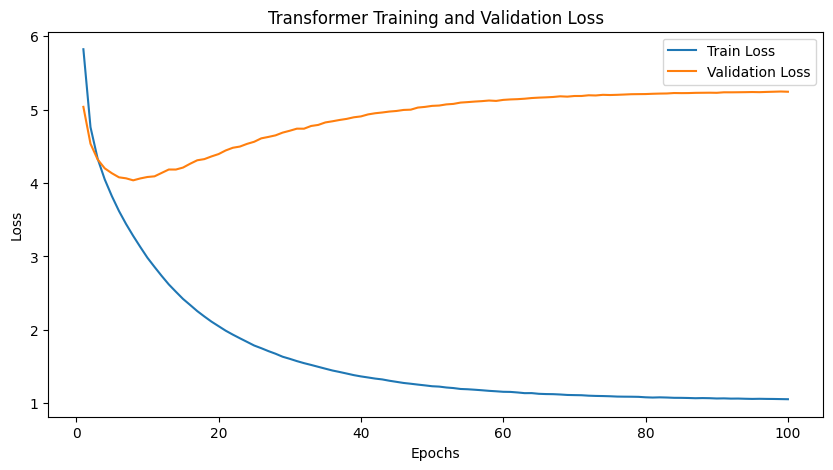

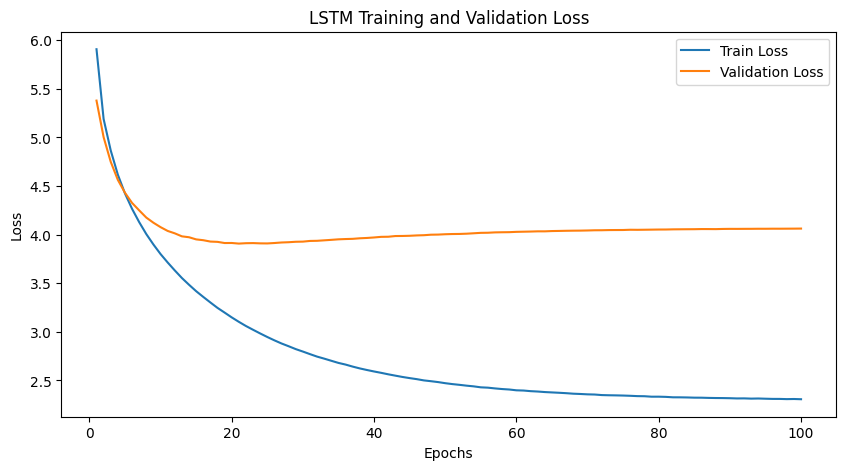

/tmp/ipykernel_30/66499072.py:478: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_transformer_model.pth', map_location=device))
/tmp/ip

English: In the beginning God created the heaven and the earth.
Transformer Urdu Translation: اور خدا کی تمجید اور اس کے ساتھ ہوتی رہے مین
LSTM Urdu Translation: سب چیزیں ہیں
--------------------------------------------------
English: And God said, Let there be light: and there was light.
Transformer Urdu Translation: اور خدا کی قسم جو اس کے سبب سے مسیح یسوع میں ہیں
LSTM Urdu Translation: نے کہا کہ
--------------------------------------------------
English: For God so loved the world, that he gave his only begotten Son.
Transformer Urdu Translation: کیونکہ خدا کی قسم جو ہم کو اس کے ساتھ ہیں
LSTM Urdu Translation: کیونکہ وہ سب سے زیادہ ہے
--------------------------------------------------
English: The quick brown fox jumps over the lazy dog.
Transformer Urdu Translation: پس وہ <UNK> کے <UNK> سے سلام کہو
LSTM Urdu Translation: <UNK> و <UNK> کے ساتھ تسبیح کیا کرو
--------------------------------------------------
English: How are you today?
Transformer Urdu Translation: پس تم دونوں اپنے ر

In [5]:
# Disable CUDA if not needed (You can enable CUDA if available and desired)
import os
#os.environ["CUDA_VISIBLE_DEVICES"] = ""  # Commented out to enable GPU usage

# Install necessary packages (uncomment and run if not already installed)
!pip install rouge-score
!pip install nltk
!pip install gradio
!pip install transformers

# Import necessary libraries
import re
import time
import torch
import random
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
from torch import optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from sklearn.model_selection import train_test_split
from nltk.translate.bleu_score import corpus_bleu
from nltk.translate.bleu_score import SmoothingFunction
from rouge_score import rouge_scorer  # Import the rouge_scorer module
import nltk
nltk.download('punkt')

# Set random seeds for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)

# Device configuration
print(f"CUDA Available: {torch.cuda.is_available()}")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


#############################################
# Data Preprocessing and Tokenization
#############################################

def read_lines(path):
    with open(path, encoding='utf-8') as f:
        return f.read().strip().split('\n')

# Define paths to datasets
DATA_DIR_BIBLE = '/kaggle/input/umc005-english-urdu-parallel-corpus/bible/'
DATA_DIR_QURAN = '/kaggle/input/umc005-english-urdu-parallel-corpus/quran/'

# Bible dataset paths
TRAIN_EN_PATH_BIBLE = os.path.join(DATA_DIR_BIBLE, 'train.en')
TRAIN_UR_PATH_BIBLE = os.path.join(DATA_DIR_BIBLE, 'train.ur')
DEV_EN_PATH_BIBLE = os.path.join(DATA_DIR_BIBLE, 'dev.en')
DEV_UR_PATH_BIBLE = os.path.join(DATA_DIR_BIBLE, 'dev.ur')
TEST_EN_PATH_BIBLE = os.path.join(DATA_DIR_BIBLE, 'test.en')
TEST_UR_PATH_BIBLE = os.path.join(DATA_DIR_BIBLE, 'test.ur')

# Quran dataset paths
TRAIN_EN_PATH_QURAN = os.path.join(DATA_DIR_QURAN, 'train.en')
TRAIN_UR_PATH_QURAN = os.path.join(DATA_DIR_QURAN, 'train.ur')
DEV_EN_PATH_QURAN = os.path.join(DATA_DIR_QURAN, 'dev.en')
DEV_UR_PATH_QURAN = os.path.join(DATA_DIR_QURAN, 'dev.ur')
TEST_EN_PATH_QURAN = os.path.join(DATA_DIR_QURAN, 'test.en')
TEST_UR_PATH_QURAN = os.path.join(DATA_DIR_QURAN, 'test.ur')

# Read Bible datasets
train_en_bible = read_lines(TRAIN_EN_PATH_BIBLE)
train_ur_bible = read_lines(TRAIN_UR_PATH_BIBLE)
dev_en_bible = read_lines(DEV_EN_PATH_BIBLE)
dev_ur_bible = read_lines(DEV_UR_PATH_BIBLE)
test_en_bible = read_lines(TEST_EN_PATH_BIBLE)
test_ur_bible = read_lines(TEST_UR_PATH_BIBLE)

# Read Quran datasets
train_en_quran = read_lines(TRAIN_EN_PATH_QURAN)
train_ur_quran = read_lines(TRAIN_UR_PATH_QURAN)
dev_en_quran = read_lines(DEV_EN_PATH_QURAN)
dev_ur_quran = read_lines(DEV_UR_PATH_QURAN)
test_en_quran = read_lines(TEST_EN_PATH_QURAN)
test_ur_quran = read_lines(TEST_UR_PATH_QURAN)

# Ensure alignment for each dataset
assert len(train_en_bible) == len(train_ur_bible), "Bible training data not aligned"
assert len(dev_en_bible) == len(dev_ur_bible), "Bible dev data not aligned"
assert len(test_en_bible) == len(test_ur_bible), "Bible test data not aligned"
assert len(train_en_quran) == len(train_ur_quran), "Quran training data not aligned"
assert len(dev_en_quran) == len(dev_ur_quran), "Quran dev data not aligned"
assert len(test_en_quran) == len(test_ur_quran), "Quran test data not aligned"

# Combine datasets
train_en = train_en_bible + train_en_quran
train_ur = train_ur_bible + train_ur_quran
dev_en = dev_en_bible + dev_en_quran
dev_ur = dev_ur_bible + dev_ur_quran
test_en = test_en_bible + test_en_quran
test_ur = test_ur_bible + test_ur_quran

# Combine all sentences
src_sentences = train_en + dev_en
tgt_sentences = train_ur + dev_ur

# Preprocessing function
def preprocess_sentence(sentence):
    sentence = sentence.lower().strip()
    # Remove special characters and digits
    sentence = re.sub(r"[^a-zA-Zا-ے۰-۹\s]+", "", sentence)
    # Remove extra spaces
    sentence = re.sub(r"\s+", " ", sentence)
    return sentence

# Preprocess sentences
src_sentences = [preprocess_sentence(s) for s in src_sentences]
tgt_sentences = [preprocess_sentence(s) for s in tgt_sentences]

# Tokenization
def tokenize_en(sentence):
    return sentence.split()

def tokenize_ur(sentence):
    return sentence.split()

# Build vocabulary with special tokens assigned first
from collections import Counter

def build_vocab(sentences, tokenizer, min_freq):
    token_counter = Counter()
    for sentence in sentences:
        tokens = tokenizer(sentence)
        token_counter.update(tokens)
    vocab = {'<PAD>': 0, '<UNK>': 1, '<SOS>': 2, '<EOS>': 3}
    idx = 4
    for token, freq in token_counter.items():
        if freq >= min_freq and token not in vocab:
            vocab[token] = idx
            idx += 1
    return vocab

# Build vocabularies
src_vocab = build_vocab(src_sentences, tokenize_en, min_freq=2)
tgt_vocab = build_vocab(tgt_sentences, tokenize_ur, min_freq=2)

# Save vocabulary sizes
SRC_VOCAB_SIZE = len(src_vocab)
TGT_VOCAB_SIZE = len(tgt_vocab)

print(f"SRC_VOCAB_SIZE: {SRC_VOCAB_SIZE}")
print(f"TGT_VOCAB_SIZE: {TGT_VOCAB_SIZE}")

# Indexing sentences
def sentence_to_indices(sentence, vocab, tokenizer):
    return [vocab.get(token, vocab['<UNK>']) for token in tokenizer(sentence)]

src_indices = [sentence_to_indices(s, src_vocab, tokenize_en) for s in src_sentences]
tgt_indices = [sentence_to_indices(s, tgt_vocab, tokenize_ur) for s in tgt_sentences]

# Filter out empty sequences
def filter_empty_sequences(src_indices, tgt_indices):
    filtered_src_indices = []
    filtered_tgt_indices = []
    for src_seq, tgt_seq in zip(src_indices, tgt_indices):
        if len(src_seq) > 0 and len(tgt_seq) > 0:
            filtered_src_indices.append(src_seq)
            filtered_tgt_indices.append(tgt_seq)
    return filtered_src_indices, filtered_tgt_indices

src_indices, tgt_indices = filter_empty_sequences(src_indices, tgt_indices)

# Add <SOS> and <EOS> tokens
tgt_indices = [[tgt_vocab['<SOS>']] + seq + [tgt_vocab['<EOS>']] for seq in tgt_indices]

# Split into training and validation sets
train_src_indices, val_src_indices, train_tgt_indices, val_tgt_indices = train_test_split(
    src_indices, tgt_indices, test_size=0.1, random_state=SEED)

#############################################
# Dataset and DataLoader
#############################################

class TranslationDataset(Dataset):
    def __init__(self, src_data, tgt_data):
        self.src_data = src_data
        self.tgt_data = tgt_data

    def __len__(self):
        return len(self.src_data)

    def __getitem__(self, idx):
        return torch.tensor(self.src_data[idx], dtype=torch.long), torch.tensor(self.tgt_data[idx], dtype=torch.long)

def collate_fn(batch):
    src_batch, tgt_batch = zip(*batch)
    src_batch = pad_sequence(src_batch, padding_value=src_vocab['<PAD>'], batch_first=True)
    tgt_batch = pad_sequence(tgt_batch, padding_value=tgt_vocab['<PAD>'], batch_first=True)
    return src_batch.to(device), tgt_batch.to(device)

BATCH_SIZE = 32

train_dataset = TranslationDataset(train_src_indices, train_tgt_indices)
val_dataset = TranslationDataset(val_src_indices, val_tgt_indices)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

#############################################
# Transformer Model Implementation
#############################################

import math
from torch.nn import Transformer

class TransformerModel(nn.Module):
    def __init__(self, src_vocab_size, tgt_vocab_size, d_model=512, nhead=8,
                 num_encoder_layers=3, num_decoder_layers=3, dim_feedforward=512, dropout=0.1):
        super(TransformerModel, self).__init__()
        self.model_type = 'Transformer'

        self.src_tok_emb = nn.Embedding(src_vocab_size, d_model)
        self.tgt_tok_emb = nn.Embedding(tgt_vocab_size, d_model)
        self.positional_encoding = PositionalEncoding(d_model, dropout)

        self.transformer = Transformer(d_model=d_model, nhead=nhead,
                                       num_encoder_layers=num_encoder_layers,
                                       num_decoder_layers=num_decoder_layers,
                                       dim_feedforward=dim_feedforward, dropout=dropout)

        self.generator = nn.Linear(d_model, tgt_vocab_size)

        self.d_model = d_model

    def forward(self, src, tgt, src_mask, tgt_mask, src_padding_mask, tgt_padding_mask, memory_key_padding_mask):
        src_emb = self.positional_encoding(self.src_tok_emb(src) * math.sqrt(self.d_model))
        tgt_emb = self.positional_encoding(self.tgt_tok_emb(tgt) * math.sqrt(self.d_model))
        memory = self.transformer(src_emb.transpose(0,1), tgt_emb.transpose(0,1), src_mask=src_mask, tgt_mask=tgt_mask,
                                  src_key_padding_mask=src_padding_mask,
                                  tgt_key_padding_mask=tgt_padding_mask,
                                  memory_key_padding_mask=memory_key_padding_mask)
        output = self.generator(memory.transpose(0,1))
        return output

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1).float()
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * -(math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        if d_model % 2 == 1:
            pe[:, 1::2] = torch.cos(position * div_term[:-1])
        else:
            pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1), :].to(x.device)
        return self.dropout(x)

# Hyperparameters tuning (can be adjusted)
d_model = 512
nhead = 8
num_encoder_layers = 3
num_decoder_layers = 3
dim_feedforward = 1024
dropout = 0.1

model = TransformerModel(SRC_VOCAB_SIZE, TGT_VOCAB_SIZE, d_model, nhead, num_encoder_layers,
                         num_decoder_layers, dim_feedforward, dropout).to(device)

criterion = nn.CrossEntropyLoss(ignore_index=tgt_vocab['<PAD>'])
optimizer = optim.Adam(model.parameters(), lr=0.0005)

scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.95)

#############################################
# LSTM Model Implementation
#############################################

class Seq2SeqLSTM(nn.Module):
    def __init__(self, src_vocab_size, tgt_vocab_size, embed_size=256, hidden_size=512, num_layers=2, dropout=0.1):
        super(Seq2SeqLSTM, self).__init__()
        self.embedding_src = nn.Embedding(src_vocab_size, embed_size)
        self.embedding_tgt = nn.Embedding(tgt_vocab_size, embed_size)
        self.encoder = nn.LSTM(embed_size, hidden_size, num_layers, dropout=dropout, batch_first=True)
        self.decoder = nn.LSTM(embed_size, hidden_size, num_layers, dropout=dropout, batch_first=True)
        self.fc_out = nn.Linear(hidden_size, tgt_vocab_size)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src, tgt):
        # Encoder
        embedded_src = self.dropout(self.embedding_src(src))
        encoder_outputs, (hidden, cell) = self.encoder(embedded_src)
        
        # Decoder
        embedded_tgt = self.dropout(self.embedding_tgt(tgt))
        decoder_outputs, _ = self.decoder(embedded_tgt, (hidden, cell))
        
        outputs = self.fc_out(decoder_outputs)
        return outputs

# Initialize LSTM model
lstm_model = Seq2SeqLSTM(SRC_VOCAB_SIZE, TGT_VOCAB_SIZE).to(device)

criterion_lstm = nn.CrossEntropyLoss(ignore_index=tgt_vocab['<PAD>'])
optimizer_lstm = optim.Adam(lstm_model.parameters(), lr=0.0005)
scheduler_lstm = optim.lr_scheduler.StepLR(optimizer_lstm, step_size=1, gamma=0.95)

#############################################
# Training and Evaluation Functions
#############################################

def generate_square_subsequent_mask(sz):
    mask = torch.triu(torch.ones(sz, sz)) == 1
    mask = mask.transpose(0, 1)
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    return mask.to(device)

def create_mask(src, tgt):
    src_seq_len = src.size(1)
    tgt_seq_len = tgt.size(1)
    
    tgt_mask = generate_square_subsequent_mask(tgt_seq_len)
    src_mask = torch.zeros((src_seq_len, src_seq_len)).type(torch.bool).to(device)
    
    src_padding_mask = (src == src_vocab['<PAD>']).to(device)
    tgt_padding_mask = (tgt == tgt_vocab['<PAD>']).to(device)
    return src_mask, tgt_mask, src_padding_mask, tgt_padding_mask

def train_epoch_transformer(model, optimizer):
    model.train()
    losses = 0
    for src, tgt in train_loader:
        tgt_input = tgt[:, :-1]
        tgt_output = tgt[:, 1:]

        src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input)

        logits = model(src, tgt_input, src_mask, tgt_mask, src_padding_mask, tgt_padding_mask, src_padding_mask)
        
        optimizer.zero_grad()
        
        loss = criterion(logits.reshape(-1, logits.shape[-1]), tgt_output.reshape(-1))
        loss.backward()
        
        optimizer.step()
        losses += loss.item()
    return losses / len(train_loader)

def evaluate_transformer(model):
    model.eval()
    losses = 0
    with torch.no_grad():
        for src, tgt in val_loader:
            tgt_input = tgt[:, :-1]
            tgt_output = tgt[:, 1:]
            
            src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input)
            
            logits = model(src, tgt_input, src_mask, tgt_mask, src_padding_mask, tgt_padding_mask, src_padding_mask)
            loss = criterion(logits.reshape(-1, logits.shape[-1]), tgt_output.reshape(-1))
            losses += loss.item()
    return losses / len(val_loader)

def train_epoch_lstm(model, optimizer):
    model.train()
    losses = 0
    for src, tgt in train_loader:
        tgt_input = tgt[:, :-1]
        tgt_output = tgt[:, 1:]

        optimizer.zero_grad()
        
        outputs = model(src, tgt_input)
        
        loss = criterion_lstm(outputs.reshape(-1, outputs.shape[-1]), tgt_output.reshape(-1))
        loss.backward()
        
        optimizer.step()
        losses += loss.item()
    return losses / len(train_loader)

def evaluate_lstm(model):
    model.eval()
    losses = 0
    with torch.no_grad():
        for src, tgt in val_loader:
            tgt_input = tgt[:, :-1]
            tgt_output = tgt[:, 1:]
            
            outputs = model(src, tgt_input)
            loss = criterion_lstm(outputs.reshape(-1, outputs.shape[-1]), tgt_output.reshape(-1))
            losses += loss.item()
    return losses / len(val_loader)

#############################################
# Training the Models
#############################################

NUM_EPOCHS = 100

# Training Transformer Model
best_val_loss = float('inf')
train_losses = []
val_losses = []

for epoch in range(1, NUM_EPOCHS + 1):
    start_time = time.time()
    train_loss = train_epoch_transformer(model, optimizer)
    val_loss = evaluate_transformer(model)
    end_time = time.time()
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_transformer_model.pth')
    
    scheduler.step()
    
    print(f"Transformer Epoch: {epoch}, Train Loss: {train_loss:.3f}, Val Loss: {val_loss:.3f}, Time: {end_time - start_time:.2f}s")

# Training LSTM Model
best_val_loss_lstm = float('inf')
train_losses_lstm = []
val_losses_lstm = []

for epoch in range(1, NUM_EPOCHS + 1):
    start_time = time.time()
    train_loss = train_epoch_lstm(lstm_model, optimizer_lstm)
    val_loss = evaluate_lstm(lstm_model)
    end_time = time.time()
    train_losses_lstm.append(train_loss)
    val_losses_lstm.append(val_loss)
    
    if val_loss < best_val_loss_lstm:
        best_val_loss_lstm = val_loss
        torch.save(lstm_model.state_dict(), 'best_lstm_model.pth')
    
    scheduler_lstm.step()
    
    print(f"LSTM Epoch: {epoch}, Train Loss: {train_loss:.3f}, Val Loss: {val_loss:.3f}, Time: {end_time - start_time:.2f}s")

#############################################
# Plotting Training and Validation Loss Curves
#############################################

# Plot for Transformer model
plt.figure(figsize=(10,5))
plt.plot(range(1, NUM_EPOCHS + 1), train_losses, label='Train Loss')
plt.plot(range(1, NUM_EPOCHS + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Transformer Training and Validation Loss')
plt.legend()
plt.show()

# Plot for LSTM model
plt.figure(figsize=(10,5))
plt.plot(range(1, NUM_EPOCHS + 1), train_losses_lstm, label='Train Loss')
plt.plot(range(1, NUM_EPOCHS + 1), val_losses_lstm, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('LSTM Training and Validation Loss')
plt.legend()
plt.show()

#############################################
# Testing the Models with Example Sentences
#############################################

# Load the best saved models
model.load_state_dict(torch.load('best_transformer_model.pth', map_location=device))
lstm_model.load_state_dict(torch.load('best_lstm_model.pth', map_location=device))

# Function to translate a sentence using the Transformer model
def translate_sentence_transformer(model, src_sentence):
    model.eval()
    src_sentence = preprocess_sentence(src_sentence)
    src_indices = [sentence_to_indices(src_sentence, src_vocab, tokenize_en)]
    src_tensor = pad_sequence([torch.tensor(src_indices[0], dtype=torch.long)], padding_value=src_vocab['<PAD>'], batch_first=True).to(device)
    num_tokens = src_tensor.size(1)
    src_mask = torch.zeros((num_tokens, num_tokens)).type(torch.bool).to(device)
    
    with torch.no_grad():
        src_emb = model.positional_encoding(model.src_tok_emb(src_tensor) * math.sqrt(model.d_model)).transpose(0,1)
        memory = model.transformer.encoder(src_emb, src_mask)
        ys = torch.ones(1, 1).fill_(tgt_vocab['<SOS>']).type(torch.long).to(device)
        for i in range(100):  # max length
            tgt_emb = model.positional_encoding(model.tgt_tok_emb(ys) * math.sqrt(model.d_model)).transpose(0,1)
            tgt_mask = generate_square_subsequent_mask(ys.size(1)).type(torch.bool).to(device)
            out = model.transformer.decoder(tgt_emb, memory, tgt_mask)
            out = model.generator(out.transpose(0,1)[:, -1])
            prob = out.softmax(dim=1)
            next_word = prob.argmax(dim=1).item()
            ys = torch.cat([ys, torch.ones(1, 1).type_as(src_tensor.data).fill_(next_word)], dim=1)
            if next_word == tgt_vocab['<EOS>']:
                break
    tgt_indices = ys[0, 1:].cpu().numpy()
    idx_to_word = {idx: word for word, idx in tgt_vocab.items()}
    tgt_tokens = [idx_to_word.get(idx, '<UNK>') for idx in tgt_indices]
    return ' '.join(tgt_tokens).replace('<EOS>', '').strip()

# Function to translate a sentence using the LSTM model
def translate_sentence_lstm(model, src_sentence):
    model.eval()
    src_sentence = preprocess_sentence(src_sentence)
    src_indices = [sentence_to_indices(src_sentence, src_vocab, tokenize_en)]
    src_tensor = pad_sequence([torch.tensor(src_indices[0], dtype=torch.long)], padding_value=src_vocab['<PAD>'], batch_first=True).to(device)
    
    with torch.no_grad():
        embedded_src = model.dropout(model.embedding_src(src_tensor))
        encoder_outputs, (hidden, cell) = model.encoder(embedded_src)
        
        ys = torch.ones(1, 1).fill_(tgt_vocab['<SOS>']).type(torch.long).to(device)
        outputs = []
        for i in range(100):  # max length
            embedded_tgt = model.dropout(model.embedding_tgt(ys))
            decoder_outputs, (hidden, cell) = model.decoder(embedded_tgt, (hidden, cell))
            output = model.fc_out(decoder_outputs[:, -1, :])
            prob = output.softmax(dim=1)
            next_word = prob.argmax(dim=1).item()
            ys = torch.cat([ys, torch.ones(1, 1).type_as(src_tensor.data).fill_(next_word)], dim=1)
            if next_word == tgt_vocab['<EOS>']:
                break
            outputs.append(next_word)
    idx_to_word = {idx: word for word, idx in tgt_vocab.items()}
    tgt_tokens = [idx_to_word.get(idx, '<UNK>') for idx in outputs]
    return ' '.join(tgt_tokens).replace('<EOS>', '').strip()

# Testing the models with some example sentences
example_sentences = [
    "In the beginning God created the heaven and the earth.",
    "And God said, Let there be light: and there was light.",
    "For God so loved the world, that he gave his only begotten Son.",
    "The quick brown fox jumps over the lazy dog.",
    "How are you today?"
]

for sentence in example_sentences:
    translation_transformer = translate_sentence_transformer(model, sentence)
    translation_lstm = translate_sentence_lstm(lstm_model, sentence)
    print(f"English: {sentence}")
    print(f"Transformer Urdu Translation: {translation_transformer}")
    print(f"LSTM Urdu Translation: {translation_lstm}")
    print("-" * 50)

#############################################
# Evaluation Metrics: BLEU and ROUGE Scores
#############################################

def translate_test_set_transformer(model):
    model.eval()
    translations = []
    with torch.no_grad():
        for src_sentence in test_en:
            translation = translate_sentence_transformer(model, src_sentence)
            translations.append(translation)
    return translations

def translate_test_set_lstm(model):
    model.eval()
    translations = []
    with torch.no_grad():
        for src_sentence in test_en:
            translation = translate_sentence_lstm(model, src_sentence)
            translations.append(translation)
    return translations

# Get translations for the test set
test_translations_transformer = translate_test_set_transformer(model)
test_translations_lstm = translate_test_set_lstm(lstm_model)

# Prepare references and hypotheses for BLEU and ROUGE calculations
references = [[preprocess_sentence(tgt_sentence).split()] for tgt_sentence in test_ur]
hypotheses_transformer = [preprocess_sentence(t).split() for t in test_translations_transformer]
hypotheses_lstm = [preprocess_sentence(t).split() for t in test_translations_lstm]

# Calculate BLEU score
smoothie = SmoothingFunction().method4
bleu_transformer = corpus_bleu(references, hypotheses_transformer, smoothing_function=smoothie)
bleu_lstm = corpus_bleu(references, hypotheses_lstm, smoothing_function=smoothie)
print(f"Transformer BLEU Score on Test Set: {bleu_transformer * 100:.2f}")
print(f"LSTM BLEU Score on Test Set: {bleu_lstm * 100:.2f}")

# Calculate ROUGE-L Score using rouge-score package
def calculate_rouge(hypotheses, references):
    scorer = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)
    rouge_scores = []
    for hyp, ref in zip(hypotheses, references):
        hyp_text = ' '.join(hyp)
        ref_text = ' '.join(ref[0])
        scores = scorer.score(ref_text, hyp_text)
        rouge_scores.append(scores['rougeL'].fmeasure)
    return np.mean(rouge_scores)

rouge_transformer = calculate_rouge(hypotheses_transformer, references)
rouge_lstm = calculate_rouge(hypotheses_lstm, references)
print(f"Transformer ROUGE-L Score on Test Set: {rouge_transformer * 100:.2f}")
print(f"LSTM ROUGE-L Score on Test Set: {rouge_lstm * 100:.2f}")

#############################################
# Comparative Analysis
#############################################

# Training time, Memory usage, Inference speed, Perplexity

# Assuming you have collected the necessary metrics during training

def calculate_perplexity(loss):
    return np.exp(loss)

perplexity_transformer = calculate_perplexity(best_val_loss)
perplexity_lstm = calculate_perplexity(best_val_loss_lstm)

print(f"Transformer Perplexity: {perplexity_transformer:.2f}")
print(f"LSTM Perplexity: {perplexity_lstm:.2f}")

# Memory usage (if using GPU)
if torch.cuda.is_available():
    transformer_memory = torch.cuda.max_memory_allocated() / (1024**2)  # in MB
    lstm_memory = torch.cuda.max_memory_allocated() / (1024**2)  # in MB
    print(f"Transformer Memory Usage: {transformer_memory:.2f} MB")
    print(f"LSTM Memory Usage: {lstm_memory:.2f} MB")

# Inference speed
import time

def measure_inference_time(model, translate_fn, sentences):
    start_time = time.time()
    for sentence in sentences:
        translate_fn(model, sentence)
    end_time = time.time()
    return (end_time - start_time) / len(sentences)

inference_time_transformer = measure_inference_time(model, translate_sentence_transformer, test_en[:100])
inference_time_lstm = measure_inference_time(lstm_model, translate_sentence_lstm, test_en[:100])

print(f"Transformer Inference Time per Sentence: {inference_time_transformer:.4f}s")
print(f"LSTM Inference Time per Sentence: {inference_time_lstm:.4f}s")

